In [61]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import pandas as pd

coor_data = pd.read_csv('Data/coordata.csv')
date_data = pd.read_csv('Data/datedata.csv')
meta_data = pd.read_csv('Data/metadata.csv')
bus_stop_data = pd.read_csv('Data/bus_stop.csv')
cluster_group_data = pd.read_csv('Data/cluster_group.csv')

general = pd.read_csv('Data/ScooterData_July15_Sept27_2019.csv')

data_set = coor_data.join(cluster_group_data.join(bus_stop_data.join(date_data.join(meta_data))))

from scipy import stats
# set_test = general[['trip_duration_min','trip_length_km']]
# data_set = data_set[(np.abs(stats.zscore(set_test)) < 3).all(axis=1)]
# general = general[(np.abs(stats.zscore(set_test)) < 3).all(axis=1)]




general_np = general.to_numpy()

# # filter
# data_set = data_set[np.logical_not(general_np[:, 6] > 10)]
# general_np = general_np[np.logical_not(general_np[:,6] > 10)]
# data_set = data_set[np.logical_not(general_np[:,6] < 0.01)]
# general_np = general_np[np.logical_not(general_np[:,6] < 0.01)]
# data_set = data_set[np.logical_not(general_np[:,5] > 120)]
# general_np = general_np[np.logical_not(general_np[:,5] > 120)]
# data_set = data_set[np.logical_not(general_np[:,5] < 1)]
# general_np = general_np[np.logical_not(general_np[:,5] < 1)]

Y_data = data_set[['endx', 'endy']].to_numpy()
X_data = data_set.drop(columns=['endx', 'endy','start_date', 'end_near_stop','end_cluster_group']).to_numpy()

In [63]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

sc = MinMaxScaler(feature_range=(0,1))
X_data_n = sc.fit_transform(X_data)
Y_data_n = sc.fit_transform(Y_data)

x_train, x_test, y_train, y_test = train_test_split(X_data_n, Y_data_n, test_size=0.4, shuffle=False)

In [88]:
from tensorflow.keras import layers, Model
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
inputA = layers.Input(shape=(4))
inputB = layers.Input(shape=(61))

# x = Dense(50, activation="relu")(inputA)
x = Dense(15)(inputA)
x = Dense(30, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
y = Dense(62)(inputB)
y = Dense(70, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

combined = layers.concatenate([x.output, y.output])

final = Dense(55, activation="softmax")(combined)
# b = Dense(2)(final)
# combined = layers.concatenate([final, b])
a = Dense(2)(final)

model = Model(inputs=[x.input,y.input], outputs=a)
model.summary()

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 61)]         0                                            
__________________________________________________________________________________________________
dense_61 (Dense)                (None, 7)            35          input_21[0][0]                   
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 62)           3844        input_22[0][0]                   
___________________________________________________________________________________________

In [70]:
from tensorflow.python.keras.callbacks import EarlyStopping

model.compile(loss="mean_absolute_error", optimizer="adam")

callback = EarlyStopping(monitor='loss', patience=5, mode="auto")
# history = model.fit([x_train[:,0:7],x_train[:,7:]], [y_train[:,0:2], y_train[:,2:4]], epochs=100, validation_data=([x_test[:,0:7],x_test[:,7:]], [y_test[:,0:2], y_test[:,2:4]]))

history = model.fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=100, validation_data=([x_test[:,0:4],x_test[:,4:]], y_test))

Train on 275686 samples, validate on 183792 samples
Epoch 1/100
275686/275686 [==============================] - 11s 41us/sample - loss: 0.0285 - val_loss: 0.0199
Epoch 2/100
275686/275686 [==============================] - 11s 40us/sample - loss: 0.0197 - val_loss: 0.0188
Epoch 3/100
275686/275686 [==============================] - 11s 40us/sample - loss: 0.0188 - val_loss: 0.0187
Epoch 4/100
275686/275686 [==============================] - 11s 40us/sample - loss: 0.0186 - val_loss: 0.0188
Epoch 5/100
275686/275686 [==============================] - 11s 40us/sample - loss: 0.0185 - val_loss: 0.0183
Epoch 6/100
275686/275686 [==============================] - 11s 39us/sample - loss: 0.0185 - val_loss: 0.0188
Epoch 7/100
275686/275686 [==============================] - 11s 39us/sample - loss: 0.0184 - val_loss: 0.0187
Epoch 8/100
275686/275686 [==============================] - 11s 39us/sample - loss: 0.0184 - val_loss: 0.0183
Epoch 9/100
275686/275686 [==============================] -

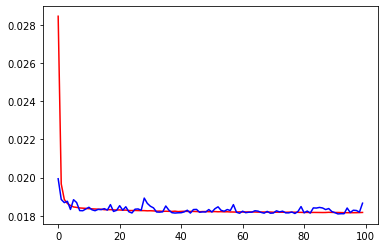

In [81]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.show()

In [82]:
model.evaluate([x_test[:,0:7],x_test[:,7:]], y_test)

ValueError: Error when checking input: expected input_19 to have shape (4,) but got array with shape (7,)

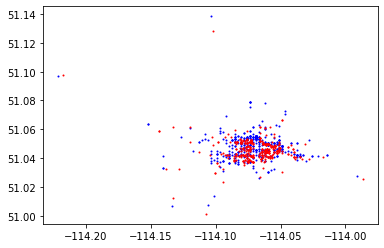

In [83]:
import matplotlib.pyplot as plt
import numpy as np
sc.fit_transform(Y_data)
result_Y = model.predict([x_test[:,0:4],x_test[:,4:]])

result_Y_plot = sc.inverse_transform(result_Y)
y_test_plot = sc.inverse_transform(y_test)

plt.scatter((y_test_plot[0:500,0]),(y_test_plot[0:500,1]), color='b', s= 1)
plt.scatter((result_Y_plot[0:500,0]), (result_Y_plot[0:500,1]), color='r', s= 1)



In [84]:
def haversine(coord1: object, coord2: object):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 5)
    km = round(km, 5)
    return km

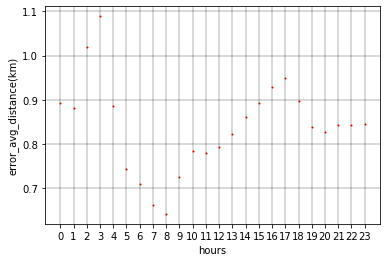

In [85]:
mae_rate_hour = []

sc.fit_transform(X_data)
x_test_hour = sc.inverse_transform(x_test)

sc.fit_transform(Y_data)
result_Y_hour = sc.inverse_transform(result_Y)
y_test_hour = sc.inverse_transform(y_test)
for index in range(24):
    mask = np.logical_and(x_test_hour[:,4] > (index)-0.2, x_test_hour[:,4] < (index+1)-0.2)
    result_Y_d = result_Y_hour[mask]
    Y_test_in = y_test_hour[mask]
    error = 0
    for i in range(len(Y_test_in)):
        error = error + haversine(result_Y_d[i,0:2],Y_test_in[i,0:2])
    end = error/len(Y_test_in)
    error_average_distance = end

    y_test[:,0] = y_test[:,0]
    mae_rate_hour.append([float(error_average_distance), str(index)])

mae_rate_hour = np.array(mae_rate_hour, dtype=np.object)
plt.xlabel('hours')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_hour[:,1], mae_rate_hour[:,0], color='r', s= 1)


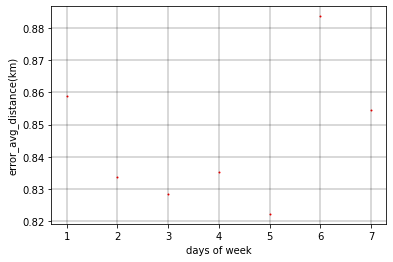

In [86]:
mae_rate_day_of_week = []

sc.fit_transform(X_data)
x_test_day = sc.inverse_transform(x_test)

sc.fit_transform(Y_data)
result_Y_day = sc.inverse_transform(result_Y)
y_test_day = sc.inverse_transform(y_test)
for index in range(7):
    mask = np.logical_and(x_test_day[:,5] > (index)-0.1, x_test_day[:,5] < (index+1)-0.1)
    result_Y_d_day = result_Y_day[mask]
    Y_test_in = y_test_day[mask]
    error = 0
    haverList = []
    for i in (range(len(Y_test_in))):
        error = error + haversine(result_Y_d_day[i,0:2],Y_test_in[i,0:2])
    end = error/len(Y_test_in)
    error_average_distance = end

    y_test[:,0] = y_test[:,0]
    mae_rate_day_of_week.append([error_average_distance, str(index+1)])

mae_rate_day_of_week = np.array(mae_rate_day_of_week, dtype=np.object)
plt.xlabel('days of week')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_day_of_week[:,1], mae_rate_day_of_week[:,0], color='r', s= 1)

In [87]:
result_Y_all = sc.inverse_transform(result_Y)
y_test_all = sc.inverse_transform(y_test)
error_all = 0
for i in (range(len(Y_test_in))):
    error_all = error_all + haversine(result_Y_d_day[i],Y_test_in[i])
    error_avg = error/len(Y_test_in)
round(error_avg, 3)

0.854